In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, f1_score
from joblib import dump, load

# Random seed 설정
random_seed = 42
np.random.seed(random_seed)


# Case1

1. raw data 모든 컬럼(int,float형 데이터) 사용 (이상치 제거X)
2. 라벨 인코딩

## Data Load

- train set -> train, val
    - model훈련 -> train 
    - model평가 -> val 

최종 model 선택 후 
- val set -> test set.
    - model최종평가 -> test

In [2]:
# train data
label_path = "./data/train/label/"
raw_path = "./data/train/raw/"

train_label = pd.read_csv(label_path+"1.걸음걸이/training_label.csv")
train_activity = pd.read_csv(raw_path+'train_activity.csv')
train_sleep = pd.read_csv(raw_path+'train_sleep.csv')

In [3]:
def merge_split(df1, df2, label):
    '''
    기능: 1. activity,sleep concat
         2. label merge
    '''
    df = pd.concat([df1, df2.drop('EMAIL',axis=1)], axis=1)
    label.rename(columns={"SAMPLE_EMAIL": "EMAIL"}, inplace=True)
    df = df.merge(label, how='inner', on="EMAIL")

    y = df.iloc[:,-1]
    X = df.select_dtypes(include=[int, float])

    print('X:{}'.format(X.shape))
    print('y:{}'.format(y.shape))

    return X, y


# 모델 훈련 함수
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

# 평가 함수
def evaluate_model(model, X, y, encoder, dataset_name="Dataset"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    print(f"=== {dataset_name} Evaluation ===")
    print(f"Accuracy: {acc:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(classification_report(y, y_pred, target_names=encoder.classes_))
    # print("="*60)

# 모델 저장 함수
def save_model(model, model_name, folder="saved_models"):
    os.makedirs(folder, exist_ok=True)
    model_path = os.path.join(folder, f"{model_name.replace(' ', '_')}.joblib")
    dump(model, model_path)
    print(f"Model saved to {model_path}")

# 모델 불러오기 함수
def load_model(model_path):
    return load(model_path)

# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed)
}

In [4]:
X, y = merge_split(train_activity, train_sleep, train_label)

X:(9705, 51)
y:(9705,)


In [5]:
# 라벨 인코딩
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.transform(y) 

In [6]:
label_encoder.classes_ # 알파벳 순으로 정렬 후 변환 CN, Dem, MCI

array(['CN', 'Dem', 'MCI'], dtype=object)

In [7]:
# 데이터 스케일링
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [8]:
# split train, val (test는 이미 있으므로)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y,
                                                  test_size = 0.2, 
                                                  random_state = random_seed,
                                                  shuffle=True,
                                                  stratify = y
                                                  )
print('X_train: {}, y_train: {}'.format(X_train.shape, y_train.shape))
print('X_val  : {}, y_val  : {}'.format(X_val.shape, y_val.shape))

X_train: (7764, 51), y_train: (7764,)
X_val  : (1941, 51), y_val  : (1941,)


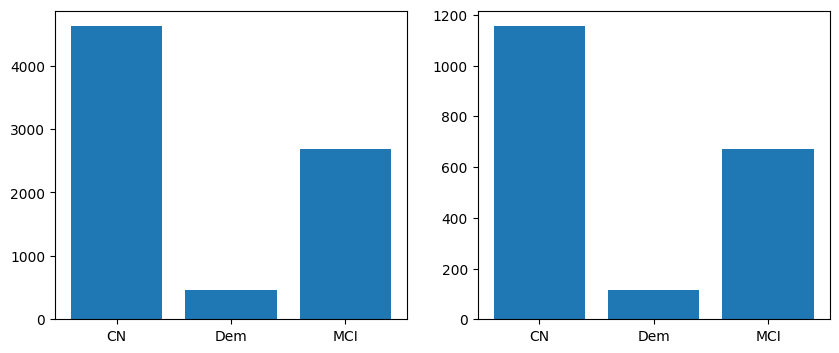

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
train_df=pd.Series(y_train).value_counts().reset_index()
val_df=pd.Series(y_val).value_counts().reset_index()

axes[0].bar(data=train_df, x='index', height='count')
axes[1].bar(data=val_df, x='index', height='count')
# plt.xticks(np.arange(0,3), ['CN', 'Dem', 'MCI'])
axes[0].set_xticks(np.arange(0,3), ['CN', 'Dem', 'MCI'])
axes[1].set_xticks(np.arange(0,3), ['CN', 'Dem', 'MCI'])
axes[0].set_xlabel('')
axes[1].set_xlabel('')
plt.show()

## Train and Evaluate Models

In [10]:
# 모델 학습 및 평가
models = {
    "Lasso Regression": LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr'),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=random_seed),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed)
}

In [11]:
# 모델 학습 및 평가
encoder = label_encoder
trained_LR = train_model(models["Lasso Regression"], X_train, y_train)
trained_DT = train_model(models["Decision Tree"], X_train, y_train)
trained_SVM = train_model(models["Support Vector Machine"], X_train, y_train)
trained_GB = train_model(models["Gradient Boosting"], X_train, y_train)

evaluate_model(trained_LR, X_train, y_train, encoder, dataset_name="Lasso Regression Train")
evaluate_model(trained_LR, X_val, y_val, encoder, dataset_name="Lasso Regression Validation")
print("="*60)
evaluate_model(trained_DT, X_train, y_train, encoder, dataset_name="Decision Tree Train")
evaluate_model(trained_DT, X_val, y_val, encoder, dataset_name="Decision Tree Validation")
print("="*60)
evaluate_model(trained_SVM, X_train, y_train, encoder, dataset_name="Support Vector Machine Train")
evaluate_model(trained_SVM, X_val, y_val, encoder, dataset_name="Support Vector Machine Validation")
print("="*60)
evaluate_model(trained_GB, X_train, y_train, encoder, dataset_name="Gradient Boosting Train")
evaluate_model(trained_GB, X_val, y_val, encoder, dataset_name="Gradient Boosting Validation")

=== Lasso Regression Train Evaluation ===
Accuracy: 0.64
F1-score: 0.62
              precision    recall  f1-score   support

          CN       0.66      0.86      0.75      4625
         Dem       0.74      0.37      0.49       457
         MCI       0.56      0.32      0.41      2682

    accuracy                           0.64      7764
   macro avg       0.65      0.52      0.55      7764
weighted avg       0.63      0.64      0.62      7764

=== Lasso Regression Validation Evaluation ===
Accuracy: 0.64
F1-score: 0.61
              precision    recall  f1-score   support

          CN       0.66      0.85      0.74      1156
         Dem       0.75      0.39      0.51       114
         MCI       0.55      0.32      0.41       671

    accuracy                           0.64      1941
   macro avg       0.65      0.52      0.55      1941
weighted avg       0.63      0.64      0.61      1941

=== Decision Tree Train Evaluation ===
Accuracy: 1.00
F1-score: 1.00
              precis

## Save Model

In [12]:
# 3. 모델 저장
# 모델 저장 디렉토리 생성
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

save_model(trained_SVM, "svm_v0")

Model saved to saved_models/svm_v0.joblib


# Case2 사람별 통계치 계산 후 분류

In [13]:
def statistic_person(data, features):
    data_summary = data.groupby('EMAIL')[features].agg(['mean', 'std']).reset_index()
    data_summary.columns = ['_'.join(col).strip('_') for col in data_summary.columns]
    return data_summary

In [14]:
act_features=train_activity.select_dtypes(include=[int, float]).columns
sleep_features=train_sleep.select_dtypes(include=[int, float]).columns

act_train=statistic_person(train_activity, act_features)
sleep_train=statistic_person(train_sleep, sleep_features)

In [15]:
X, y = merge_split(act_train, sleep_train, train_label)

X:(141, 102)
y:(141,)


In [16]:
X_scaled = scaler.fit_transform(X)
y=label_encoder.transform(y)

In [17]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y,
                                                  test_size = 0.2, 
                                                  random_state = random_seed,
                                                  shuffle=True,
                                                  stratify = y
                                                  )
print('X_train: {}, y_train: {}'.format(X_train.shape, y_train.shape))
print('X_val  : {}, y_val  : {}'.format(X_val.shape, y_val.shape))

X_train: (112, 102), y_train: (112,)
X_val  : (29, 102), y_val  : (29,)


In [18]:
# 모델 학습 및 평가
encoder = label_encoder
trained_LR = train_model(models["Lasso Regression"], X_train, y_train)
trained_DT = train_model(models["Decision Tree"], X_train, y_train)
trained_SVM = train_model(models["Support Vector Machine"], X_train, y_train)
trained_GB = train_model(models["Gradient Boosting"], X_train, y_train)

evaluate_model(trained_LR, X_train, y_train, encoder, dataset_name="Lasso Regression Train")
evaluate_model(trained_LR, X_val, y_val, encoder, dataset_name="Lasso Regression Validation")
print("="*60)
evaluate_model(trained_DT, X_train, y_train, encoder, dataset_name="Decision Tree Train")
evaluate_model(trained_DT, X_val, y_val, encoder, dataset_name="Decision Tree Validation")
print("="*60)
evaluate_model(trained_SVM, X_train, y_train, encoder, dataset_name="Support Vector Machine Train")
evaluate_model(trained_SVM, X_val, y_val, encoder, dataset_name="Support Vector Machine Validation")
print("="*60)
evaluate_model(trained_GB, X_train, y_train, encoder, dataset_name="Gradient Boosting Train")
evaluate_model(trained_GB, X_val, y_val, encoder, dataset_name="Gradient Boosting Validation")

=== Lasso Regression Train Evaluation ===
Accuracy: 0.89
F1-score: 0.89
              precision    recall  f1-score   support

          CN       0.90      0.93      0.91        68
         Dem       1.00      0.71      0.83         7
         MCI       0.86      0.86      0.86        37

    accuracy                           0.89       112
   macro avg       0.92      0.84      0.87       112
weighted avg       0.89      0.89      0.89       112

=== Lasso Regression Validation Evaluation ===
Accuracy: 0.38
F1-score: 0.37
              precision    recall  f1-score   support

          CN       0.50      0.53      0.51        17
         Dem       0.00      0.00      0.00         2
         MCI       0.18      0.20      0.19        10

    accuracy                           0.38        29
   macro avg       0.23      0.24      0.23        29
weighted avg       0.36      0.38      0.37        29

=== Decision Tree Train Evaluation ===
Accuracy: 1.00
F1-score: 1.00
              precis

# Evaluate Test data

** 마지막에 실행 ** 
- 삭제해도 됨

In [19]:
# validation -> test data
label_path = "./data/validation/label/"
raw_path = "./data/validation/raw/"

test_label = pd.read_csv(label_path+"1.걸음걸이/val_label.csv")
test_activity = pd.read_csv(raw_path+'val_activity.csv')
test_sleep = pd.read_csv(raw_path+'val_sleep.csv')

In [20]:
X_test, y_test = merge_split(test_activity, test_sleep, test_label)

X:(2478, 51)
y:(2478,)


In [21]:
X_test_scaled = scaler.fit_transform(X_test)
y_test_labeled = label_encoder.transform(y_test)

In [22]:
# 저장된 모델 불러오기
model = load_model("saved_models/svm_v0.joblib")

In [23]:
# Test 데이터에 모델 적용
y_test_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test_labeled, y_test_pred)
test_f1 = f1_score(y_test_labeled, y_test_pred, average='weighted')
print(f"Test Accuracy: {test_acc:.2f}")
print(f"Test F1-score: {test_f1:.2f}")
print(classification_report(y_test_labeled, y_test_pred, target_names=label_encoder.classes_))
print("="*60)

Test Accuracy: 0.64
Test F1-score: 0.65
              precision    recall  f1-score   support

          CN       0.77      0.78      0.77      1956
         Dem       0.79      0.18      0.29       214
         MCI       0.07      0.11      0.09       308

    accuracy                           0.64      2478
   macro avg       0.54      0.35      0.38      2478
weighted avg       0.69      0.64      0.65      2478

